<a href="https://colab.research.google.com/github/PRIYANSHU-8055/Projects/blob/main/distilbert%2Bensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import re

In [ ]:
# Load the datasets
real_news = pd.read_csv('True.csv')
fake_news = pd.read_csv('Fake.csv')

# Add labels
real_news['label'] = 0  # 0 for real news
fake_news['label'] = 1  # 1 for fake news

# Combine the datasets
news_data = pd.concat([real_news, fake_news], axis=0).reset_index(drop=True)

#**EDA**


In [ ]:
# Preprocess the text
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = text.lower()  # Convert to lowercase
    return text

news_data['text'] = news_data['text'].apply(clean_text)

In [ ]:
# Split into training and test sets
X = news_data['text']
y = news_data['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#**DISTILBERT** **MODEL**

In [ ]:
from transformers import DistilBertTokenizer, DistilBertModel
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load pre-trained DistilBERT model and tokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

# Device configuration (use GPU if available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
distilbert_model = distilbert_model.to(device)

/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [ ]:
# Tokenize and encode text into tensors for batch processing
def encode_texts(texts, tokenizer, max_len=512):
    encodings = tokenizer.batch_encode_plus(
        texts.tolist(),
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='pt'
    )
    return encodings['input_ids'], encodings['attention_mask']

# Encode training and test data
X_train_input_ids, X_train_attention_mask = encode_texts(X_train, tokenizer)
X_test_input_ids, X_test_attention_mask = encode_texts(X_test, tokenizer)


In [ ]:
# Create TensorDatasets and DataLoaders for training and test sets
train_dataset = TensorDataset(X_train_input_ids, X_train_attention_mask)
test_dataset = TensorDataset(X_test_input_ids, X_test_attention_mask)

# Define DataLoader with batch size
batch_size = 32  # Adjust batch size depending on your GPU/CPU memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [ ]:
# Function to extract DistilBERT embeddings in batches
def get_distilbert_embeddings(dataloader, model):
    model.eval()  # Set model to evaluation mode
    embeddings_list = []

    with torch.no_grad():  # Disable gradient calculation
        for batch in dataloader:
            # Unpack the batch
            input_ids, attention_mask = batch
            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)

            # Get DistilBERT output
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Get the mean of the hidden states for each sentence (sentence embeddings)
            embeddings = torch.mean(outputs.last_hidden_state, dim=1)
            embeddings_list.append(embeddings.cpu())

    return torch.cat(embeddings_list, dim=0)


In [ ]:
# Extract DistilBERT embeddings for training and test sets
X_train_bert = get_distilbert_embeddings(train_loader, distilbert_model)
X_test_bert = get_distilbert_embeddings(test_loader, distilbert_model)

#**ENSEMBLE APPROACH**

In [ ]:
from sklearn.svm import SVC  # Import SVC (Support Vector Classifier)
from sklearn.ensemble import RandomForestClassifier  # Import RandomForestClassifier
from sklearn.ensemble import StackingClassifier  # Import StackingClassifier
from sklearn.preprocessing import StandardScaler  # Import StandardScaler for scaling
from sklearn.model_selection import cross_val_score  # Import cross_val_score for cross-validation
from sklearn.metrics import classification_report, confusion_matrix  # Metrics for evaluation


# Standardize the BERT embeddings before trainin
scaler = StandardScaler()

# Fit the scaler on training data and transform both train and test sets
X_train_bert_scaled = scaler.fit_transform(X_train_bert.numpy())
X_test_bert_scaled = scaler.transform(X_test_bert.numpy())


In [ ]:
# Define the base classifiers
svm_clf = SVC(probability=True)  # SVM classifier
rf_clf = RandomForestClassifier(n_estimators=100)  # Random Forest classifier

# Define the stacking ensemble with SVM and Random Forest
stacking_clf = StackingClassifier(
    estimators=[
        ('svm', svm_clf),
        ('rf', rf_clf)
    ],
    final_estimator=SVC(probability=True)
)

#**EVALUATION**

Ensemble Model Accuracy: 0.9870824053452116


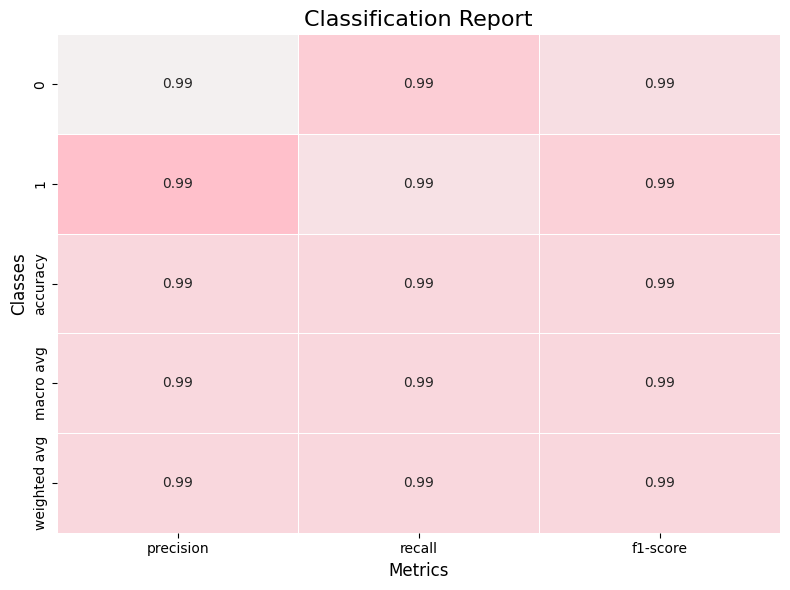

In [ ]:
# Train the ensemble model on the entire training set
stacking_clf.fit(X_train_bert_scaled, y_train)

accuracy = stacking_clf.score(X_test_bert_scaled, y_test)
print(f'Ensemble Model Accuracy: {accuracy}')

# Predict on the test set
y_pred = stacking_clf.predict(X_test_bert_scaled)

# Classification report
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

def plot_classification_report(y_test, y_pred):
    # Generate the classification report as a dictionary
    report = classification_report(y_test, y_pred, output_dict=True)

    # Convert the report dictionary to a Pandas DataFrame for easier manipulation
    report_df = pd.DataFrame(report).transpose()

    # Select the desired rows to display ('0', '1', 'accuracy', 'macro avg', 'weighted avg')
    report_df = report_df.loc[['0', '1', 'accuracy', 'macro avg', 'weighted avg'], ['precision', 'recall', 'f1-score', 'support']]

    # Create a heatmap to visualize the classification report with a pink color palette
    plt.figure(figsize=(8, 6))
    custom_palette = sns.light_palette("pink", as_cmap=True)
    sns.heatmap(report_df.iloc[:, :-1], annot=True, cmap=custom_palette, cbar=False, fmt='.2f', linewidths=0.5)

    plt.title('Classification Report', fontsize=16)
    plt.ylabel('Classes', fontsize=12)
    plt.xlabel('Metrics', fontsize=12)

    # Adjust layout for better display
    plt.tight_layout()
    plt.show()
plot_classification_report(y_test, y_pred)

In [ ]:
from sklearn.metrics import roc_curve, auc

# Calculate the ROC curve and AUC
y_scores = stacking_clf.predict_proba(X_test_bert_scaled)[:, 1]  # get the probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)


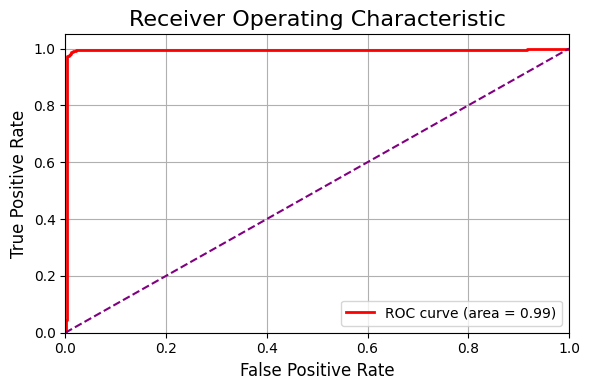

In [ ]:
# Plotting the ROC curve
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='red', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='purple', linestyle='--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.legend(loc='lower right')
plt.grid()
plt.tight_layout()
plt.show()

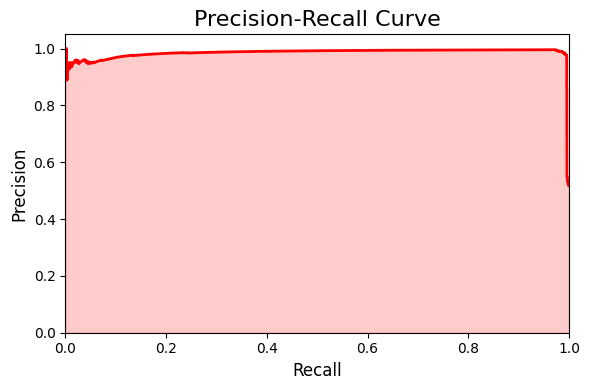

In [ ]:
from sklearn.metrics import precision_recall_curve

def plot_precision_recall_curve(y_true, y_scores):
    precision, recall, _ = precision_recall_curve(y_true, y_scores)

    plt.figure(figsize=(6, 4))
    plt.plot(recall, precision, color='red', lw=2)
    plt.fill_between(recall, precision, alpha=0.2, color='red')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall', fontsize=12)
    plt.ylabel('Precision', fontsize=12)
    plt.title('Precision-Recall Curve', fontsize=16)
    plt.tight_layout()
    plt.show()

# Call the function
plot_precision_recall_curve(y_test, y_scores)


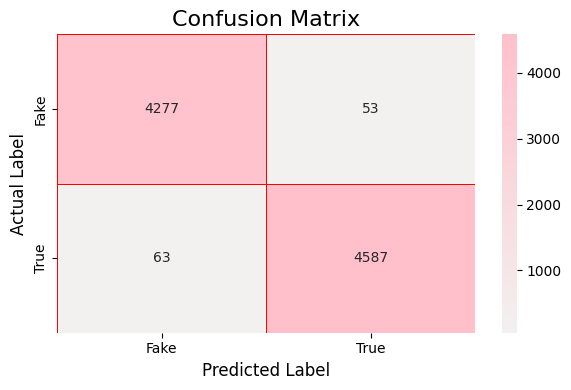

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred):
    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Set up the figure and axes
    plt.figure(figsize=(6, 4))

    # Create a custom pink color palette
    custom_pink_palette = sns.light_palette("pink", as_cmap=True)

    # Create a heatmap for the confusion matrix with a custom pink color palette
    sns.heatmap(cm, annot=True, fmt='d', cmap=custom_pink_palette,
                xticklabels=['Fake', 'True'], yticklabels=['Fake', 'True'],
                linewidths=0.5, linecolor='red')

    # Customize the title and labels
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Example usage
plot_confusion_matrix(y_test, y_pred)